In [1]:
from google.colab import files

uploaded = files.upload()

Saving reviews_dataset.csv to reviews_dataset.csv


In [13]:
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler

In [3]:

# Load dataset
df = pd.read_csv('reviews_dataset.csv')

# Define text preprocessing functions
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

# Apply text preprocessing
df['ReviewContent'] = df['ReviewContent'].apply(remove_punctuation)
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['ReviewContent'] = df['ReviewContent'].apply(remove_stopwords)
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
df['ReviewContent'] = df['ReviewContent'].apply(lemmatize_text)

# Encode categorical variables
label_encoder = LabelEncoder()
df['Category_encoded'] = label_encoder.fit_transform(df['Category'])
df['Generation_encoded'] = label_encoder.fit_transform(df['Generation'])
df['Sentiment_encoded'] = label_encoder.fit_transform(df['Sentiment'])
df['Country_encoded'] = label_encoder.fit_transform(df['Country'])

scaler = MinMaxScaler()
df['Rating_normalized'] = scaler.fit_transform(df[['Rating']])



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [8]:
# Define features and target variable
X_text = df['ReviewContent']
X_rating = df['Rating_normalized']
y = df['Sentiment_encoded']

# Stratified split into training and testing sets
X_text_train, X_text_test, X_rating_train, X_rating_test, y_train, y_test = train_test_split(X_text, X_rating, y, test_size=0.3, random_state=42, stratify=y)

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_text_train)
X_text_train_seq = tokenizer.texts_to_sequences(X_text_train)
X_text_test_seq = tokenizer.texts_to_sequences(X_text_test)

review_lengths = [len(seq) for seq in X_text_train_seq]
# Set max_len based on the 100th percentile length (longest review)
max_len = np.percentile(review_lengths, 100).astype(int)  # Use 100th percentile length

X_text_train_pad = pad_sequences(X_text_train_seq, maxlen=max_len, padding='post', truncating='post')
X_text_test_pad = pad_sequences(X_text_test_seq, maxlen=max_len, padding='post', truncating='post')
# Analyze the length distribution of the

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Alternatively, save the data to pickle files for better performance
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_test.to_pickle('y_test.pkl')

In [16]:


# Define the ANN model
embedding_dim = 128

# Text input
text_input = Input(shape=(max_len,), name='text_input')
embedding = Embedding(input_dim=5000, output_dim=embedding_dim)(text_input)
flatten = Flatten()(embedding)

# Rating input
rating_input = Input(shape=(1,), name='rating_input')

# Concatenate text and rating features
concatenated = Concatenate()([flatten, rating_input])
dense1 = Dense(128, activation='relu')(concatenated)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(64, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(4, activation='softmax')(dropout2)  # Assuming 4 classes

# Create the model
model_ann_rating = tf.keras.Model(inputs=[text_input, rating_input], outputs=output)

model_ann_rating.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_ann_rating.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_ann = model_ann_rating.fit(
    {'text_input': X_text_train_pad, 'rating_input': X_rating_train},
    y_train,
    epochs=11,  # Adjust epochs as needed
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict  # If needed, include class weights here
)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 468)]                0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 468, 128)             640000    ['text_input[0][0]']          
                                                                                                  
 flatten_3 (Flatten)         (None, 59904)                0         ['embedding_3[0][0]']         
                                                                                                  
 rating_input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                            

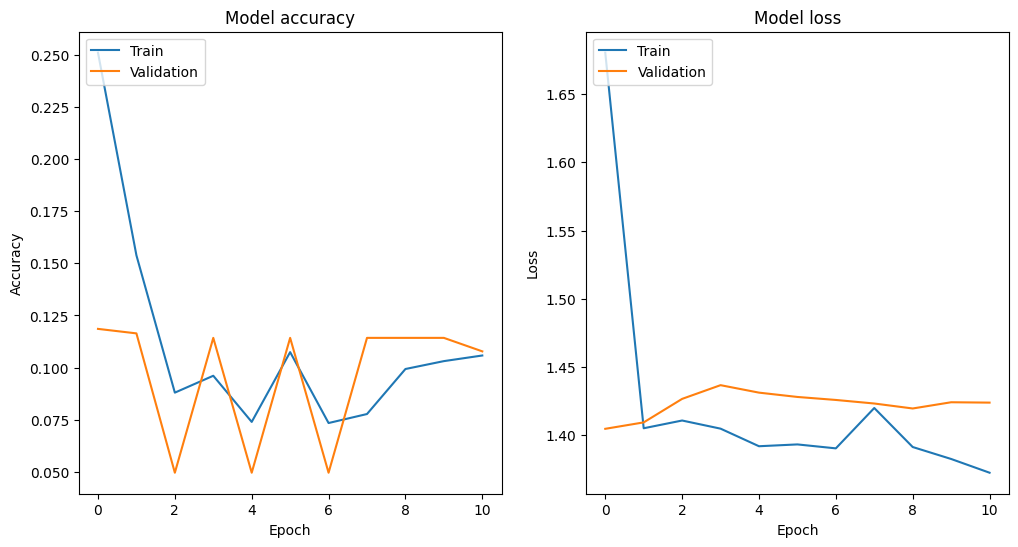

In [17]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_ann.history['accuracy'])
plt.plot(history_ann.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_ann.history['loss'])
plt.plot(history_ann.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [18]:
# Evaluate the model
y_pred_ann_rating = model_ann_rating.predict({'text_input': X_text_test_pad, 'rating_input': X_rating_test})
y_pred_classes_ann_rating = np.argmax(y_pred_ann_rating, axis=1)

print("Classification Report (ANN with Rating):")
print(classification_report(y_test, y_pred_classes_ann_rating))

# Accuracy
accuracy_ann_rating = accuracy_score(y_test, y_pred_classes_ann_rating)
print(f"Accuracy (ANN with Rating): {accuracy_ann_rating:.2f}")

32/32 [==============================] - 1s 18ms/step
Classification Report (ANN with Rating):
              precision    recall  f1-score   support

           0       0.12      0.84      0.21       125
           1       0.06      0.11      0.08        53
           2       0.00      0.00      0.00       117
           3       1.00      0.00      0.00       698

    accuracy                           0.11       993
   macro avg       0.29      0.24      0.07       993
weighted avg       0.72      0.11      0.03       993

Accuracy (ANN with Rating): 0.11


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
